In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# expansion coefficients from uniform quadrature
def coeff_uj(j,h,c,gamma):
    hj = h*j
    res = np.exp(c*(1-1j*hj))
    res *= np.exp(-(1.+hj*hj)/(4*gamma*gamma))
    res *= (h/np.pi)/(1.+hj*hj)
    return res

# elchs is the target error for LCHS
def gamma_from_elchs(c,elchs):
    return np.sqrt(c+np.log((1+0.5/np.pi)/elchs))/c

def r_from_gamma_c(c,gamma):
    return 2*c*gamma*gamma

def vofA(hj):
    return np.exp(1j*(-hj*2+np.pi))

In [3]:
# subroutine for QFT matrix (and its inverse) on n qubits
def get_qft_mat(n):
    num_states = 1<<n # this is 2**n
    omega = np.exp(-2j*np.pi/num_states)

    qft = np.zeros((num_states,num_states),dtype=complex)

    for i in range(num_states):
        for j in range(num_states):
            qft[i][j] = omega**(i*j)/np.sqrt(num_states)

    qft_inv = qft.transpose().conjugate()

    return qft, qft_inv

Here we want to solve a simple 1D diffusion equation
$$\frac{\partial}{\partial t} u(x,t) = D\frac{\partial^2}{\partial x^2} u(x,t)\quad x\in[0,L]$$
with periodic boundary conditions. We will work on a lattice discretization with $N=2^n$ lattice points and a spacing $\Delta x=L/N$ and keep time continuous. If we denote by $x_j=\Delta x j$ the coordinate of the $j-th$ site and $u_j(t)=u(x_j,t)$, we can write the discretized equation as follows
$$\frac{\partial}{\partial t} u_j(t) = \frac{D}{\Delta x^2} \sum_{l=0}^{N-1}[\mathbf{P}_2]_{jl}u_l(t)$$
where $\mathbf{P}_2$ is a finite matrix representation of the laplacian operator on the lattice.

As a test case we consider a gaussian of width $\sigma\ll L$ (so we can avoid worrying about periodic extensions) so that
$$u(x,0)=C\exp\left(-\frac{(x-L/2)^2}{4\sigma^2}\right)$$
On the discrete lattice this looks like
$$u_j(0)=C\exp\left(-\frac{(j\Delta x-L/2)^2}{4\sigma^2}\right)=C\exp\left(-\frac{(j-N/2)^2}{4\Sigma^2}\right)$$
where we introduced $\Sigma=\sigma/\Delta x$ for convenience.

In [4]:
n_qubits = 6
N_states = 1<<n_qubits
L=1
Delta_x = L/N_states
Sigma=0.5
# setting up initial state
x_index=np.arange(N_states)
x_coord = x_index*Delta_x
u0=np.exp(-0.25*((x_index-N_states/2)/Sigma)**2)
# normalization
u0/=np.sqrt(np.vdot(u0,u0))

In [5]:
qft_mat, qft_mat_inv = get_qft_mat(n_qubits)

In [6]:
# Fourier transform of input
v0=qft_mat.dot(u0)
# inverse of FT of input (should match u0)
uv0=qft_mat_inv.dot(v0)

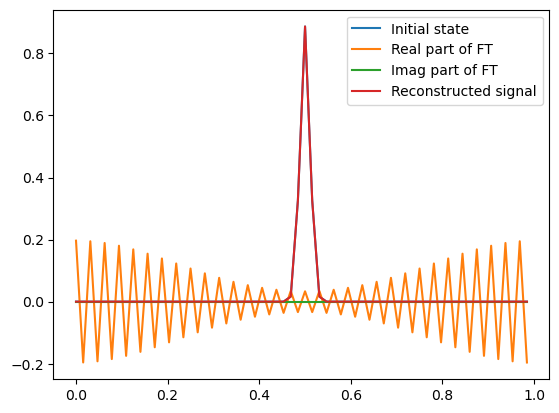

In [7]:
plt.plot(x_coord,u0,label="Initial state")
plt.plot(x_coord,np.real(v0),label="Real part of FT")
plt.plot(x_coord,np.imag(v0),label="Imag part of FT")
plt.plot(x_coord,np.real(uv0),label="Reconstructed signal")
plt.legend()
plt.show()

## Spectral method vs finite differences

In [8]:
# returns spectral version of the P_2 operator on n qubits both in real space and Fourier space
def get_P_2_op_spectral(n):
    num_states = 1<<n # this is 2**n

    n_index = np.arange(num_states,dtype=complex) # so that the result will inherit the dtype
    P_2_diag = np.diag(np.where(n_index <= num_states>>1,-(2*np.pi*n_index/num_states)**2,
                                                    -(2*np.pi*(n_index-num_states)/num_states)**2))
### explicit version with a for loop
#    P_2_diag= np.zeros((num_states,num_states),dtype=complex)
#    for n in range(num_states):
#        if n <= num_states>>1:
#            P_2_diag[n,n]=-(2*np.pi*n/num_states)**2
#        else:
#            P_2_diag[n,n]=-(2*np.pi*(n-num_states)/num_states)**2
    P_2 = qft_mat_inv.dot(P_2_diag.dot(qft_mat))

    return P_2, P_2_diag

# returns finite difference version of the P_2 operator on n qubits in real space
def get_P_2_op_finite_difference(n):
    num_states = 1<<n # this is 2**n

    A = (np.diag(-2 * np.ones(num_states)) + 
         np.diag(1 * np.ones(num_states - 1), 1) + 
         np.diag(1 * np.ones(num_states - 1), -1))
    # Periodic BCs
    A[0, num_states - 1] = 1
    A[num_states - 1, 0] = 1

    return A

In [9]:
# get P_2 operators in their spectral version
P2_sp,P2_sp_diag = get_P_2_op_spectral(n_qubits)
# get P_2 operators in their finite difference version
P2_fd = get_P_2_op_finite_difference(n_qubits)

In [10]:
# generate results with both spectral and finite difference methods
nsteps=40
dt=0.01
D = 0.01 # diffusion coefficient
diff_coeff = D/Delta_x/Delta_x # effective dimensionless coefficient for diffusion
Udiff_sp=sp.linalg.expm(dt*diff_coeff*P2_sp)
Udiff_fd=sp.linalg.expm(dt*diff_coeff*P2_fd)
ts_sp = []
ts_fd = []
ut_sp=u0
ut_fd=u0
for j in range(nsteps):
    ts_sp.append(ut_sp)
    ut_sp=Udiff_sp.dot(ut_sp)
    ts_fd.append(ut_fd)
    ut_fd=Udiff_fd.dot(ut_fd)

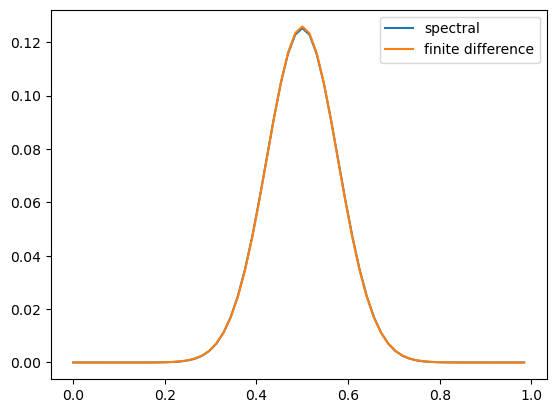

In [11]:
time_slice = 30
plt.plot(x_coord,np.real(ts_sp[time_slice]),label="spectral")
plt.plot(x_coord,np.real(ts_fd[time_slice]),label="finite difference")
plt.legend()
plt.show()

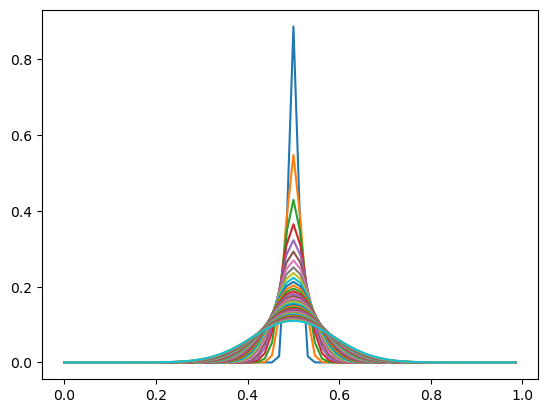

In [12]:
for n in range(nsteps):
    plt.plot(x_coord,np.real(ts_sp[n]),label="spectral")

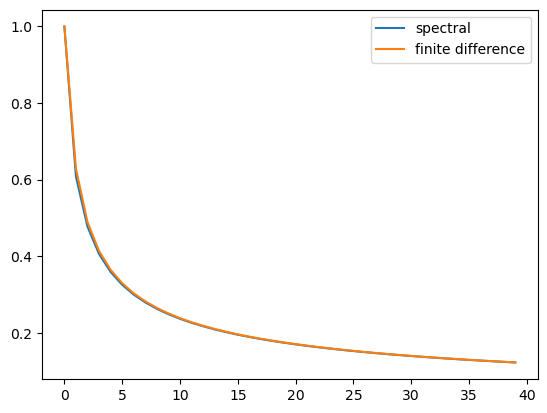

In [13]:
# we can also estimate the subnormalization of the state as it diffuses
norm_sp = np.zeros(nsteps)
norm_fd = np.zeros(nsteps)
for n in range(nsteps):
    norm_sp[n] = np.real(np.vdot(ts_sp[n],ts_sp[n]))
    norm_fd[n] = np.real(np.vdot(ts_fd[n],ts_fd[n]))
plt.plot(np.arange(nsteps),norm_sp,label="spectral")
plt.plot(np.arange(nsteps),norm_fd,label="finite difference")
plt.legend()
plt.show()

### Approximation using LCHS
We will now try to use LCHS to approximate the diffusion operator using LCHS

In [21]:
# estimate of the quadrature error given h
def get_equad(t,Lnorm,h,c):
    return 4.*np.exp((t*Lnorm+3*c)/2)/(np.exp(np.pi/h)-1)

# estimate of h given the quadrature error
def get_h_from_equad(e,Lnorm,t,c):
    return np.pi/(t*Lnorm/2+np.log(64*np.exp(3*c/2)/e/15.))

In [15]:
print(f"norm of P2_sp: {sp.linalg.norm(P2_sp,ord=2)}")
print(f"norm of P2_fd: {sp.linalg.norm(P2_fd,ord=2)}")

norm of P2_sp: 9.8696044010902
norm of P2_fd: 3.9999999999999996


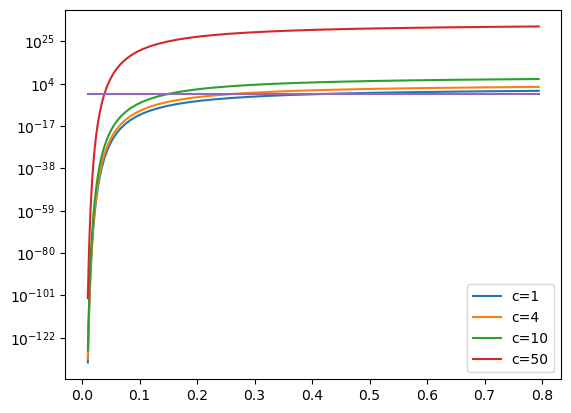

In [16]:
# checking quadrature error for diffusion as a function of h
norm_of_L = diff_coeff*(np.pi**2) # this assumes we use P2_sp
c=1.0
t=0.01
h=np.logspace(-2,-0.1,40)
err1 = get_equad(norm_of_L,t,h,1.0)
err4 = get_equad(norm_of_L,t,h,4.0)
err10 = get_equad(norm_of_L,t,h,10.0)
err50 = get_equad(norm_of_L,t,h,50.0)
plt.semilogy(h,err1,label="c=1")
plt.semilogy(h,err4,label="c=4")
plt.semilogy(h,err10,label="c=10")
plt.semilogy(h,err50,label="c=50")
plt.semilogy(h,0.1*np.ones_like(h))
plt.legend()
plt.show()

In [66]:
# this routine calculates the LHCS approximation of both
# the evolved state and the evolution operator
## deflation_param can be used to artifically decrease the number of points in the quadrature
def do_lchs_for_diffusion(initial_state,total_time,h_step,c_par,g_par,R_par,diff_gen,deflation_param=1.0,verbose=False):
    niter = np.int32(np.ceil(R_par/h_step/deflation_param))
    if verbose:
        print(f"time ({total_time}), h ({h_step}), c ({c_par}), gamma ({g_par}), R ({R_par}), num_pts ({1+2*niter})")
    # unitary version of single step diffusion operator
    Uihdiff = sp.linalg.expm(1j*total_time*h_step*diff_gen)
    # leftmost unitary operator (j=-niter)
    Uleft = sp.linalg.expm(-1j*total_time*niter*h_step*diff_gen)
    # ideal diffusion operator
    Udiff_ideal = sp.linalg.expm(total_time*diff_gen)
    # ideal vector
    vec_ideal = Udiff_ideal.dot(initial_state)
    # initial value for operator
    vj=Uleft
    # initial value for state
    vvecj=Uleft.dot(initial_state)
    # space to store resulting operator
    u_sum = np.zeros_like(vj)
    # space to store resulting vector
    v_sum = np.zeros_like(vvecj)
    # perform the summation
    for j in range(-niter,niter+1):
        uj = coeff_uj(j,h_step,c_par,g_par)
        u_sum += uj*vj
        v_sum += uj*vvecj
        # get next one
        vj = Uihdiff.dot(vj)
        vvecj = Uihdiff.dot(vvecj)

    # store results in dictionary before returning
    results_lchs = { "ideal_vec": np.real(vec_ideal), # this is the exact result for the evolved solution
                     "ideal_U": Udiff_ideal,          # this is the exact evolution operator
                     "lchs_vec": np.real(v_sum),      # this is the LCHS approximated solution 
                     "lchs_U": u_sum,                 # this is the LCHS approximated evolution operator
                   }
    return results_lchs

In [67]:
target_time=0.1
# set initial state
u0=np.exp(-0.25*((x_index-N_states/2)/Sigma)**2)
# normalization
u0/=np.sqrt(np.vdot(u0,u0))

norm_of_L = diff_coeff*(np.pi**2)
# these two are the parameters we might want to fiddle with, or we can even just pick values of h directly
target_error = 0.001
c_param = 3.0
# now we get all the derived ones
hofc = get_h_from_equad(target_error,norm_of_L,target_time,c_param)
gofc = gamma_from_elchs(c_param,target_error)
Rofc = r_from_gamma_c(c_param,gofc)
# and we do the calculation
diff_operator = diff_coeff*P2_sp
res_lchs = do_lchs_for_diffusion(u0,target_time,hofc,c_param,gofc,Rofc,diff_operator,verbose=True)

time (0.1), h (0.09499384806342934), c (3.0), gamma (1.057010802072561), R (6.703631014188472), num_pts (143)


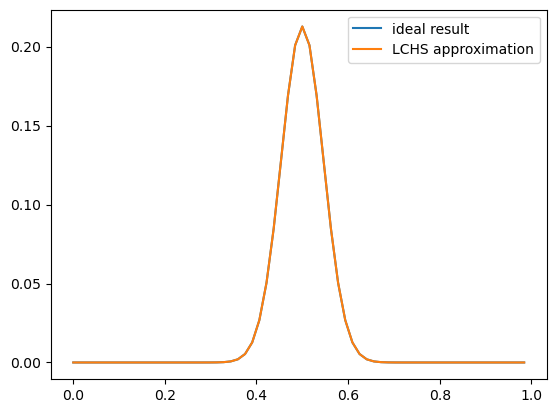

In [68]:
plt.plot(x_coord,res_lchs['ideal_vec'],label="ideal result")
plt.plot(x_coord,res_lchs['lchs_vec'],label="LCHS approximation")
plt.legend()
plt.show()

In [74]:
vec_diff = res_lchs['ideal_vec']-res_lchs['lchs_vec']
norm_diff = sp.linalg.norm(vec_diff)
print(f"-> approximation error in norm: {norm_diff}")

-> approximation error in norm: 4.467359856847448e-06


In [87]:
# let's see how much we can save by tuning the R
deflate_param = np.linspace(1,4,100)
ress = []
norms = np.zeros_like(deflate_param)
for idx in range(len(deflate_param)):
    dd = deflate_param[idx]
    res_dd = do_lchs_for_diffusion(u0,target_time,hofc,c_param,gofc,Rofc,diff_operator,deflation_param=dd)
    vec_diff = res_dd['ideal_vec']-res_dd['lchs_vec']
    norm_dd = sp.linalg.norm(vec_diff) 
    norms[idx] = norm_dd

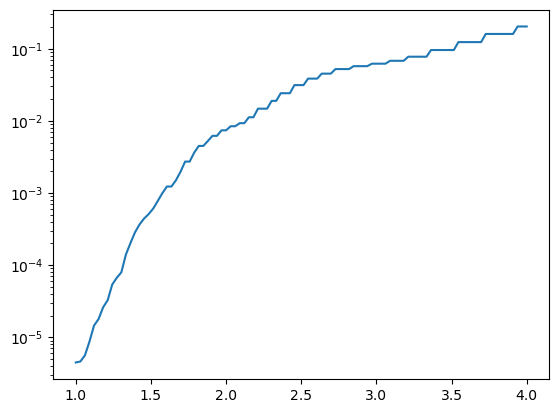

In [88]:
plt.semilogy(deflate_param,norms)

In [89]:
# let's see how much we can save by tuning h
inflate_h = np.linspace(1,20,100)
ress = []
norms_h = np.zeros_like(deflate_param)
for idx in range(len(deflate_param)):
    dd = deflate_param[idx]
    res_dd = do_lchs_for_diffusion(u0,target_time,hofc*dd,c_param,gofc,Rofc,diff_operator)
    vec_diff = res_dd['ideal_vec']-res_dd['lchs_vec']
    norm_dd = sp.linalg.norm(vec_diff) 
    norms_h[idx] = norm_dd

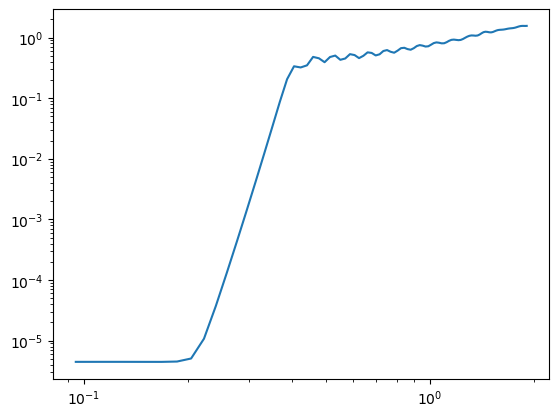

In [91]:
plt.loglog(inflate_h*hofc,norms_h)